In [1]:
## first line of code is to clear R's memory
rm(list=ls())

In [2]:
#libraries
if (!requireNamespace("EnsDb.Hsapiens.v86", quietly = TRUE))
  BiocManager::install("EnsDb.Hsapiens.v86")
library(Signac)
library(Seurat)
library(rtracklayer)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(readr)
library(qs)
library(dplyr)
library(stringr)
library(Azimuth)
library(harmony)
library(EnsDb.Hsapiens.v86)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Loading required package: SeuratObject

Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.3.1"

Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, saveRDS


Loading Seurat v5 beta version 
To maintain compatibility with previous workflows, new Seurat objects will use the previous object structure by default
To use new Seurat v5 assays: Please run: options(Seurat.object.assay.version = 'v5')

Loading required package: GenomicRange

In [41]:
#####################
#Read Initial Seurat Object and filter it
###################
seurat_object = readRDS("complete/GSE184462_merged_1_10_test.rds")

peaks <- CallPeaks(
  object = seurat_object,
  group.by = "cell.type"
)

metadata <- seurat_object[[]]
frags <- Fragments(seurat_object)


peak_matrix <- FeatureMatrix(
  fragments = frags,
  features = peaks
)

chrom_assay <- CreateChromatinAssay(
  counts = peak_matrix,
  sep = c(":", "-"),
  fragments = frags
)

SeruatObj <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata
)

SeruatObj

Processing file /mnt/DATA2/luca_histones/GSE184462_extr/fragments/GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments.sort.tsv.gz




Processing file /mnt/DATA2/luca_histones/GSE184462_extr/fragments/GSM5589345_adipose_omentum_SM-CHZRM_rep1_fragments.sort.tsv.gz




Processing file /mnt/DATA2/luca_histones/GSE184462_extr/fragments/GSM5589346_adipose_omentum_SM-CSSD4_rep1_fragments.sort.tsv.gz




Processing file /mnt/DATA2/luca_histones/GSE184462_extr/fragments/GSM5589347_adipose_omentum_SM-IOBHJ_rep1_fragments.sort.tsv.gz




Processing file /mnt/DATA2/luca_histones/GSE184462_extr/fragments/GSM5589348_adrenal_gland_SM-A8WNO_rep1_fragments.sort.tsv.gz




Processing file /mnt/DATA2/luca_histones/GSE184462_extr/fragments/GSM5589349_artery_aorta_SM-C1MLC_rep1_fragments.sort.tsv.gz




Processing file /mnt/DATA2/luca_histones/GSE184462_extr/fragments/GSM5589350_artery_aorta_SM-C1PX3_rep1_fragments.sort.tsv.gz




Processing file /mnt/DATA2/luca_histones/GSE184462_extr/fragments/GSM5589351_

In [36]:
#seurat_object <- SeruatObj
#saveRDS(SeruatObj, "complete/GSE184462_merged_1_10_newpeaks.rds")

In [3]:
seurat_object <- readRDS("complete/GSE184462_merged_1_10_newpeaks.rds")
 
#Add barcode to metadata
seurat_object$barcode <- Cells(seurat_object)

#####################
#Annotation
###################
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)

# change to UCSC style since the data was mapped to hg38
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "hg38"

# add the gene information to the object
Annotation(seurat_object) <- annotations
    


Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



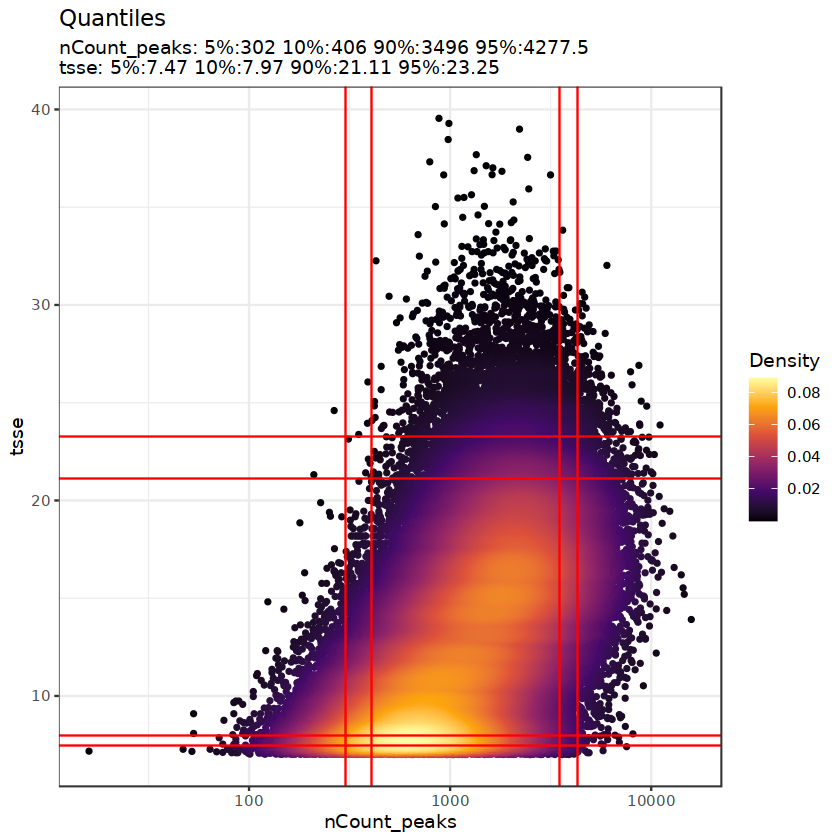

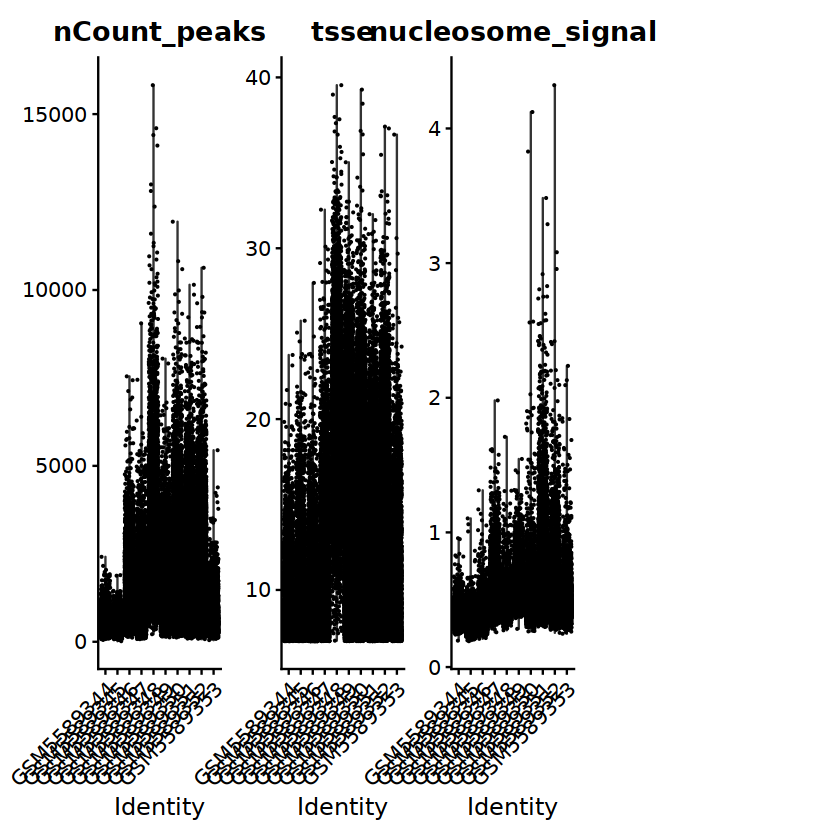

In [4]:
#####################
#QC Metrics
###################
# compute nucleosome signal score per cell
seurat_object <- NucleosomeSignal(object = seurat_object)

# compute TSS enrichment score per cell
seurat_object <- TSSEnrichment(object = seurat_object, fast = FALSE)

DensityScatter(seurat_object, x = 'nCount_peaks', y = 'tsse', log_x = TRUE, quantiles = TRUE)

VlnPlot(
  object = seurat_object,
  features = c('nCount_peaks', 'tsse', 'nucleosome_signal'),
  pt.size = 0.1,
  ncol = 5
)

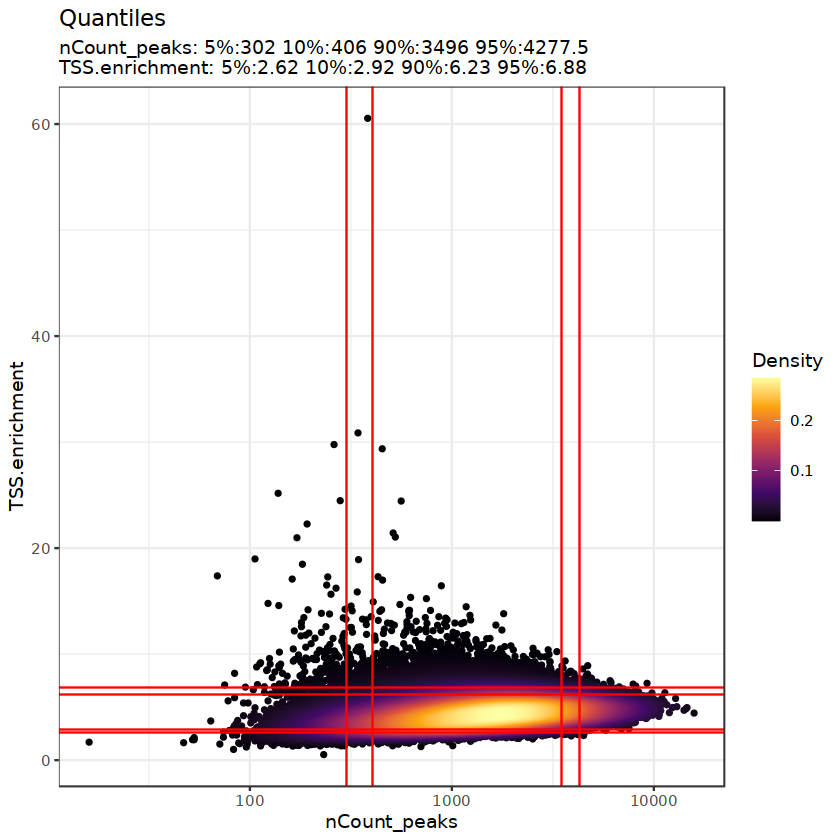

In [5]:
DensityScatter(seurat_object, x = 'nCount_peaks', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)


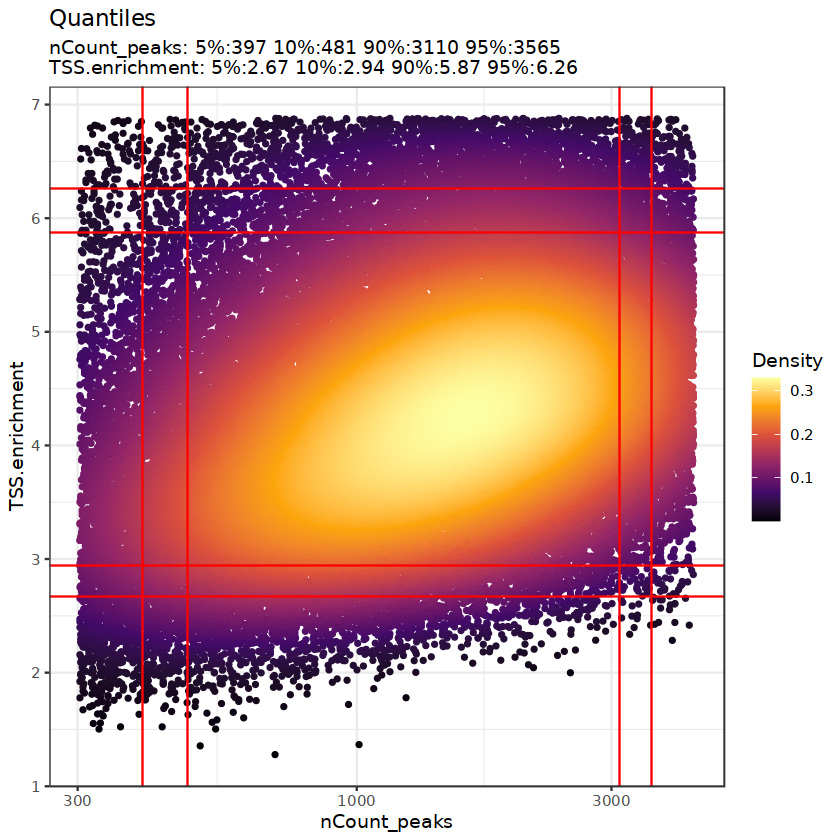

In [6]:
#filtering out bad reads
seurat_object <- subset(
    x = seurat_object,
    subset = nCount_peaks < 4277 &
    nCount_peaks > 302 &
    TSS.enrichment < 6.88
)

DensityScatter(seurat_object, x = 'nCount_peaks', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)



In [5]:
#qsave(seurat_object, "exports/GSE184462_merged_1_10_QC.rds")

In [ ]:
##########################
#Normalization and linear dimensional reduction
#########################
seurat_object <- RunTFIDF(seurat_object)
seurat_object <- FindTopFeatures(seurat_object, min.cutoff = 'q50')
seurat_object <- RunSVD(seurat_object)

DepthCor(seurat_object)





In [11]:
##########################
#Comparison to non-batchcontroled
#########################
if (FALSE){
unintegrated <- RunUMAP(seurat_object, dims = 2:50, reduction = 'lsi')
unintegrated <- FindNeighbors(object = unintegrated, reduction = 'lsi', dims = 2:30, k.param = 50)
unintegrated <- FindClusters(object = unintegrated, verbose = FALSE, algorithm = 3)
DimPlot(object = unintegrated, group.by = 'tissue') + NoLegend()
    
}



In [12]:
##########################
#Batch Correction (harmony)
#########################
if (FALSE){
seurat_object <- RunHarmony(seurat_object, group.by.vars = "tissue", reduction = 'lsi', assay.use = 'peaks', project.dim = FALSE)
seurat_object <- RunUMAP(seurat_object, reduction = "harmony", dims = 1:30)
DimPlot(seurat_object, group.by = 'tissue', pt.size = 0.1)
}


In [ ]:
##########################
#Non-linear dimension reduction and clustering
#########################
seurat_object <- RunHarmony(seurat_object, group.by.vars = "tissue", reduction = 'lsi', assay.use = 'peaks', project.dim = FALSE)
seurat_object <- RunUMAP(seurat_object, reduction = "harmony", dims = 2:30)
seurat_object <- FindNeighbors(object = seurat_object, reduction = 'harmony', dims = 2:30)
seurat_object <- FindClusters(object = seurat_object, verbose = FALSE, algorithm = 3)
DimPlot(object = seurat_object, group.by = 'tissue') + NoLegend()




In [9]:
length(unique(seurat_object$seurat_clusters))
length(unique(seurat_object$cell.type))

[1] 14

[1] 55

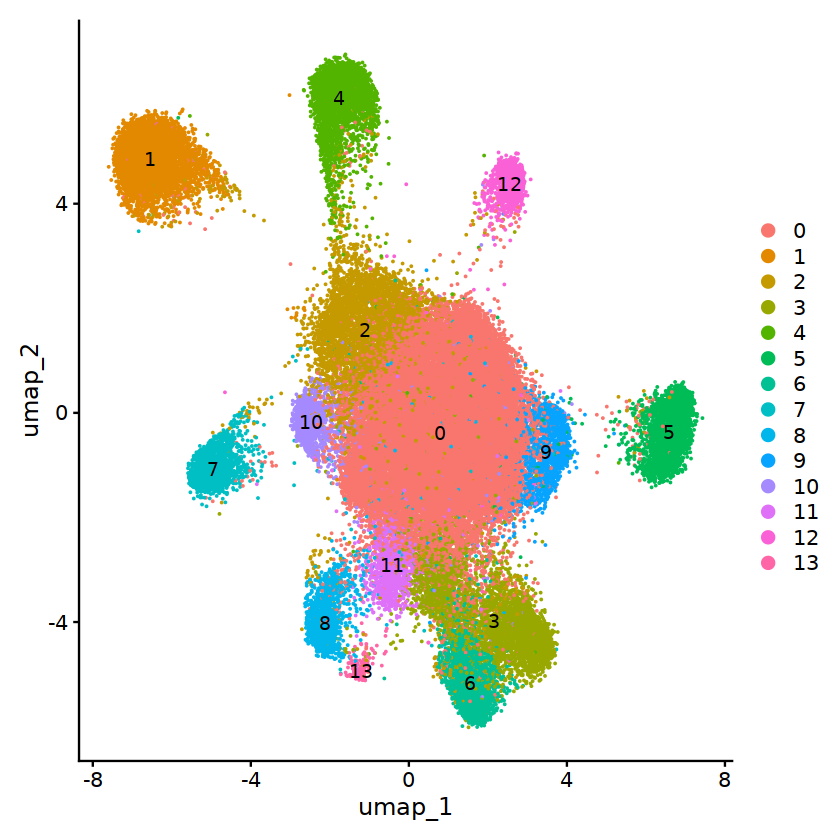

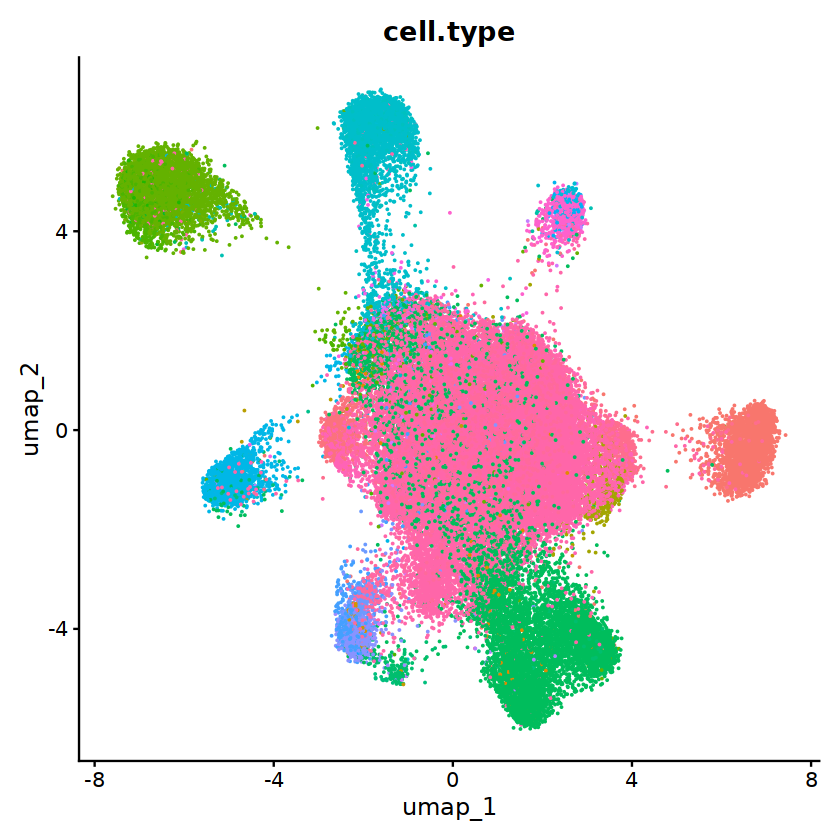

In [10]:
DimPlot(object = seurat_object, label = TRUE)
DimPlot(object = seurat_object, group.by = 'cell.type') + NoLegend()

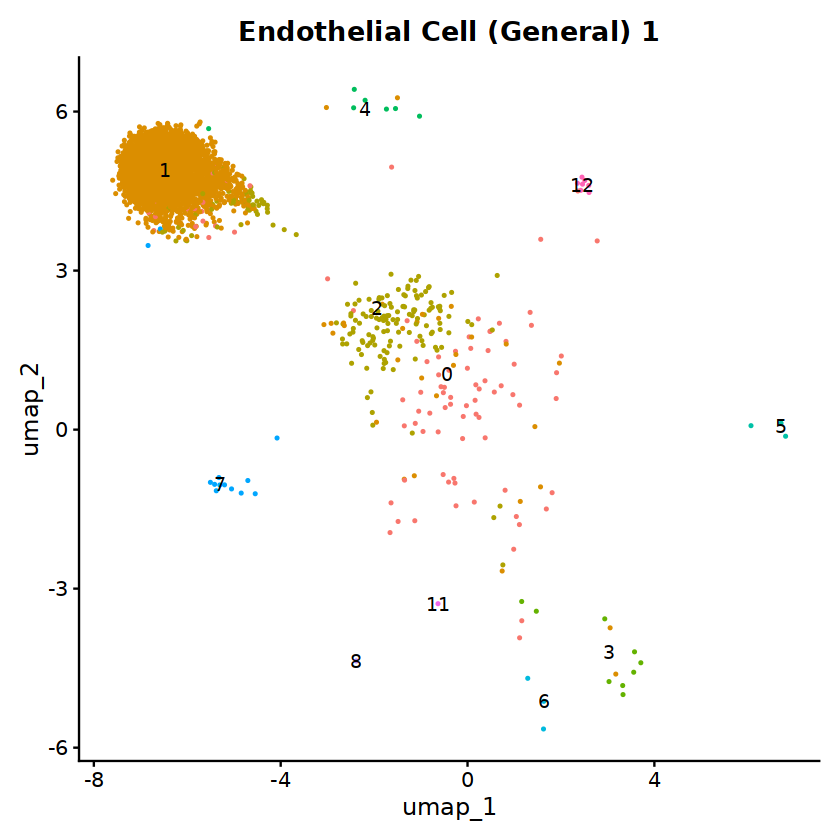

In [12]:
ct <- unique(seurat_object$cell.type)[5]
st <- subset( x = seurat_object, subset = cell.type == ct)

DimPlot(object = st, group.by = "seurat_clusters", label = TRUE) + NoLegend() + ggtitle(ct)

In [13]:
##########################
#Create a gene activity matrix
#########################
gene.activities <- GeneActivity(seurat_object)
# add the gene activity matrix to the Seurat object as a new assay and normalize it
seurat_object[['RNA']] <- CreateAssayObject(counts = gene.activities)
seurat_object <- NormalizeData(
  object = seurat_object,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(seurat_object$nCount_RNA)
)



Extracting gene coordinates

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



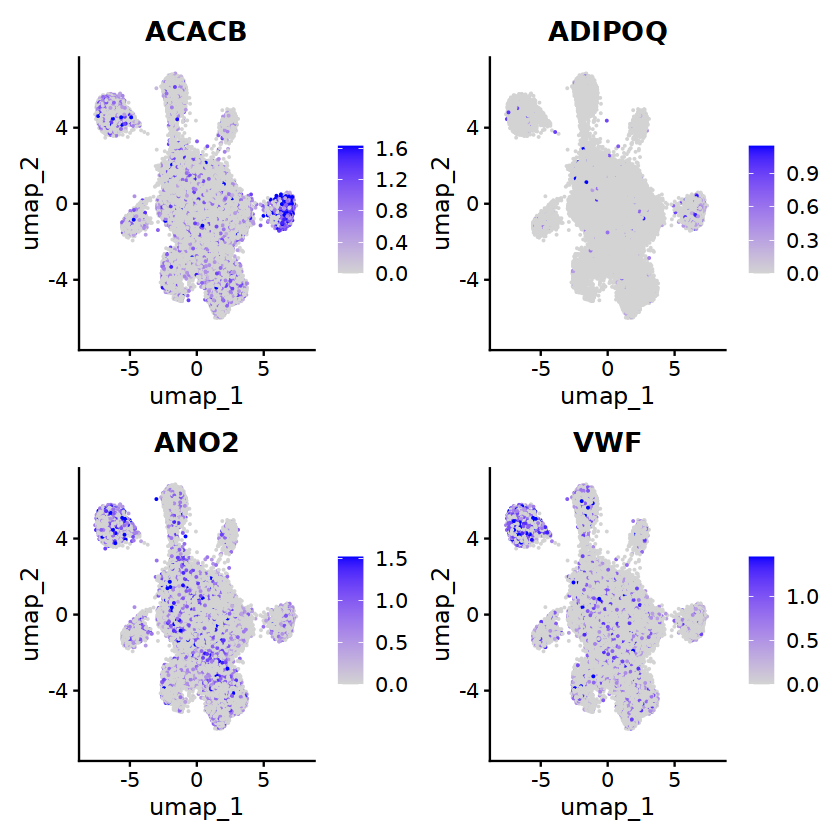

In [14]:
DefaultAssay(seurat_object) <- 'RNA'

FeaturePlot(
  object = seurat_object,
  features = c('ACACB', 'ADIPOQ', 'ANO2', 'VWF'),
  pt.size = 0.05,
  max.cutoff = 'q95',
  ncol = 2
)
#Fibroblasts: VIM, PDGFRA
#Adipocyte: LEP, HOXC8
#Endothel: LDB2, JAM2, ANO2, VWF
#Adipocytes: GPAM, ADIPOQ, ACACB, PCDH9, GHR, TRHDE, SORBS1, PLIN1, PDE3B, WDPCP

DefaultAssay(seurat_object) <- 'peaks'

In [15]:
length(Features(seurat_object[["RNA"]]))
#qsave(seurat_object, "complete/GSE184462_merged_1_10_processed.rds")

[1] 19607

In [16]:
unique(seurat_object$cell.type)

[1] "Mesothelial Cell"                       
 [2] "Fibroblast (General)"                   
 [3] "Pericyte (General) 3"                   
 [4] "Pericyte (General) 1"                   
 [5] "Endothelial Cell (General) 1"           
 [6] "Endothelial Cell (General) 2"           
 [7] "Adipocyte"                              
 [8] "Lymphatic Endothelial Cell"             
 [9] "Macrophage (General)"                   
[10] "Pericyte (General) 2"                   
[11] "Pericyte (Esophageal Muscularis)"       
[12] "Macrophage (General,Alveolar)"          
[13] "T Lymphocyte 1 (CD8+)"                  
[14] "Vascular Smooth Muscle 2"               
[15] "Cardiac Pericyte 4"                     
[16] "Endothelial Cell (General) 3"           
[17] "Vascular Smooth Muscle 1"               
[18] "Cardiac Pericyte 3"                     
[19] "Naive T cell"                           
[20] "Schwann Cell (General)"                 
[21] "Pericyte (General) 4"                   
[22] "Cardiac Pericyte 2"                     
[23] "Plasma Cell"                            
[24] "Alverolar Type 2,Immune"                
[25] "Endothelial Cell (Myocardial)"          
[26] "Mast Cell"                              
[27] "Fibroblast (Peripheral Nerve)"          
[28] "Cardiac Fibroblasts"                    
[29] "Fibroblast (Epithelial)"                
[30] "Peripheral Nerve Stromal"               
[31] "Luteal Cell (Ovarian)"                  
[32] "Small Intestinal Enterocyte"            
[33] "Smooth Muscle (General)"                
[34] "Smooth Muscle (Esophageal Muscularis) 3"
[35] "Chief Cell"                             
[36] "Natural Killer T Cell"                  
[37] "T lymphocyte 2 (CD4+)"                  
[38] "Foveolar Cell"                          
[39] "Pancreatic Acinar Cell"                 
[40] "Alveolar Capillary Endothelial Cell"    
[41] "Ductal Cell (Pancreatic)"               
[42] "Memory B Cell"                          
[43] "Transitional Zone Cortical Cell"        
[44] "Cortical Epithelial-like"               
[45] "Zona Fasciculata Cortical Cell"         
[46] "Zona Glomerulosa Cortical Cell"         
[47] "Endothelial (Exocrine Tissues)"         
[48] "Fibroblast (Liver Adrenal)"             
[49] "CNS,Enteric Neuron"                     
[50] "Smooth Muscle (Vaginal)"                
[51] "Endocardial Cell"                       
[52] "Cardiac Pericyte 1"                     
[53] "Alveolar Type 2 (AT2) Cell"             
[54] "Keratinocyte 1"                         
[55] "Smooth Muscle (GE Junction)"

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chrM-13365-16493,9.546100e-314,-1.169187,0.938,0.981,2.135415e-308
chrM-9-3843,1.935783e-305,-1.153697,0.944,0.982,4.330251e-300
chrM-12826-13122,4.684343e-217,-1.215526,0.583,0.774,1.047864e-211
chr14-38255065-38256688,1.396541e-115,-4.246825,0.007,0.123,3.123992e-110
chr20-23048354-23051273,2.912002e-104,-2.703532,0.026,0.151,6.514002e-99
chr18-12258482-12259344,1.030043e-97,6.586188,0.120,0.001,2.304155e-92


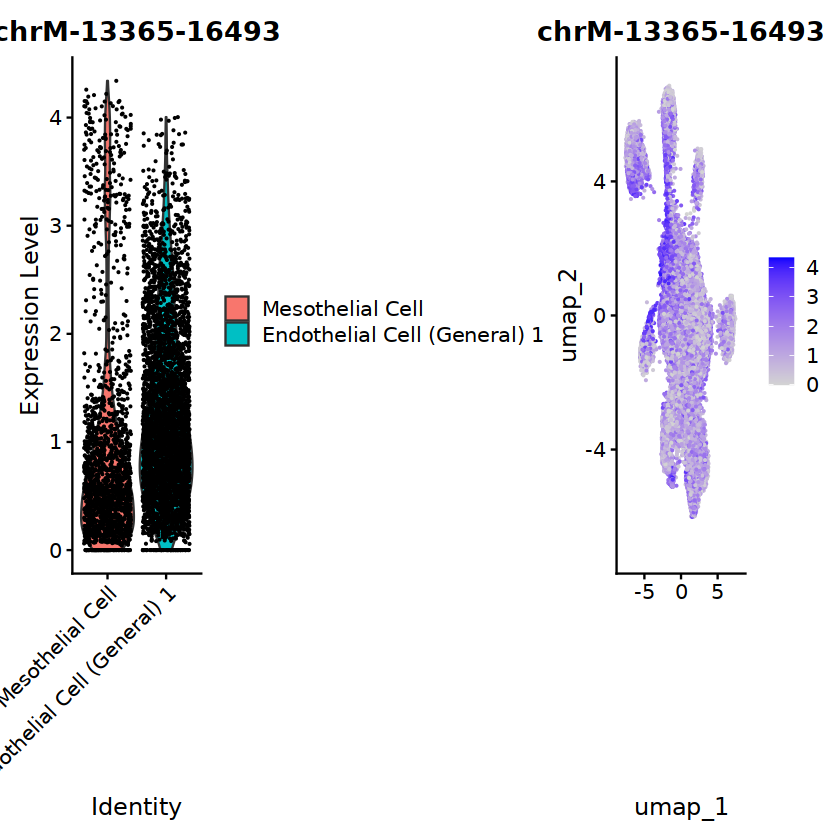

In [17]:
# change back to working with peaks instead of gene activities
DefaultAssay(seurat_object) <- 'peaks'
Idents(seurat_object) <- seurat_object$cell.type

da_peaks <- FindMarkers(
  object = seurat_object,
  ident.1 = "Adipocyte",
  ident.2 = "Endothelial Cell (General) 1",
  test.use = 'LR',
  latent.vars = 'nCount_peaks'
)

head(da_peaks)

plot1 <- VlnPlot(
  object = seurat_object,
  features = rownames(da_peaks)[1],
  pt.size = 0.1,
  idents = c("Mesothelial Cell","Endothelial Cell (General) 1")
)
plot2 <- FeaturePlot(
  object = seurat_object,
  features = rownames(da_peaks)[1],
  pt.size = 0.1
)

plot1 | plot2

In [18]:
da_peaks

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chrM-13365-16493,9.546100e-314,-1.169187,0.938,0.981,2.135415e-308
chrM-9-3843,1.935783e-305,-1.153697,0.944,0.982,4.330251e-300
chrM-12826-13122,4.684343e-217,-1.215526,0.583,0.774,1.047864e-211
chr14-38255065-38256688,1.396541e-115,-4.246825,0.007,0.123,3.123992e-110
chr20-23048354-23051273,2.912002e-104,-2.703532,0.026,0.151,6.514002e-99
chr18-12258482-12259344,1.030043e-97,6.586188,0.120,0.001,2.304155e-92
chr13-28494390-28495723,3.846792e-90,-3.949101,0.008,0.106,8.605081e-85
chr1-15798842-15800698,1.698916e-89,3.590396,0.168,0.013,3.800391e-84
chr17-14737916-14738833,3.381216e-83,5.928870,0.107,0.002,7.563612e-78


In [46]:
#seurat_object <- qread("complete/GSE184462_merged_1_10_processed.rds")

In [19]:
seurat_object_unnoramlized<- seurat_object
seurat_object_unnoramlized[['RNA']] <- NULL
seurat_object_unnoramlized[['RNA']] <- CreateAssayObject(counts = gene.activities)
DefaultAssay(seurat_object_unnoramlized) <- "RNA"

az <- RunAzimuth(seurat_object_unnoramlized,  reference = "adiposeref", assay = "RNA")

Warning message:
"Overwriting miscellanous data for model"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
detected inputs from HUMAN with id type Gene.name

reference rownames detected HUMAN with id type Gene.name

Normalizing query using reference SCT model

Warning message:
"702 features of the features specified were not present in both the reference query assays. 
Continuing with remaining 2298 features."
Projecting cell embeddings

Finding query neighbors

Finding neighborhoods

Finding anchors

	Found 2694 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Predicting cell labels


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key

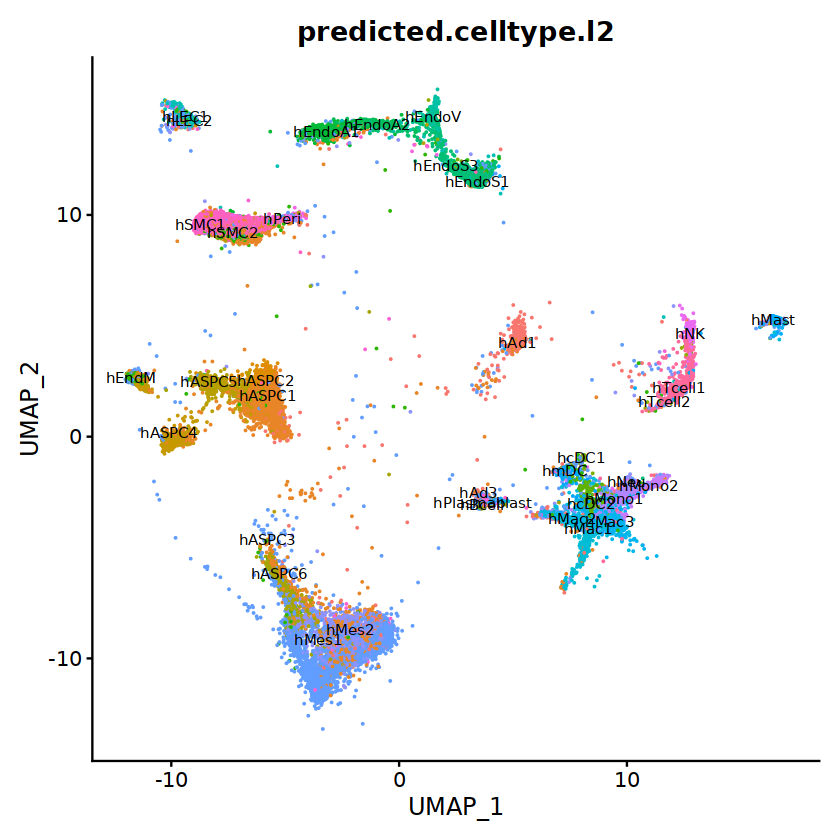

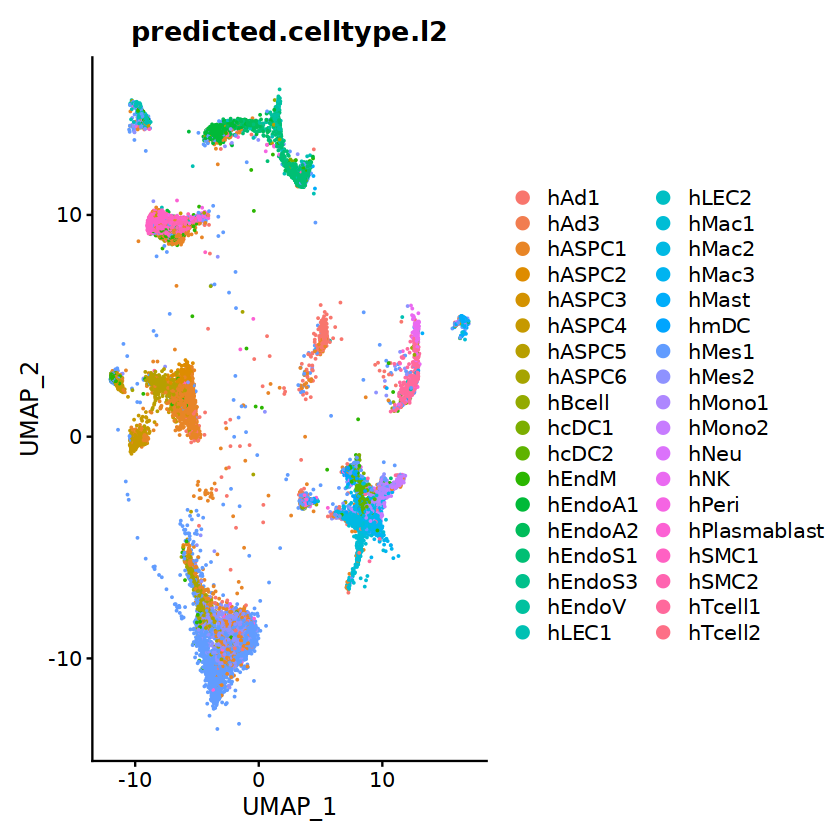

In [20]:
DimPlot(az, group.by = "predicted.celltype.l2", label = TRUE, label.size = 3) + NoLegend()
DimPlot(az, group.by = "predicted.celltype.l2")

In [21]:
az[[]][c(9,21,23)]

,cell.type,predicted.celltype.l1,predicted.celltype.l2
,<chr>,<chr>,<chr>
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGAAGTGTCGTGGA,Mesothelial Cell,Mesothelial,hEndM
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGACATGGCAAGCC,Fibroblast (General),ASPC,hASPC1
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGAGCATACTCAGC,Fibroblast (General),Smooth Muscle,hSMC1
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGAGGGATCCATTA,Fibroblast (General),ASPC,hASPC1
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGATGACCACCAAT,Fibroblast (General),ASPC,hASPC6
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGATTACTCGTGGG,Pericyte (General) 3,ASPC,hASPC1
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGCACGCAAGGGAA,Fibroblast (General),ASPC,hASPC1
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGCAGTGATTCTGT,Mesothelial Cell,ASPC,hASPC1
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGCGAACGATACAG,Pericyte (General) 1,ASPC,hASPC1


In [27]:
colnames(az[[]])

[1] "orig.ident"                  "nCount_peaks"               
 [3] "nFeature_peaks"              "sample"                     
 [5] "replicate"                   "logUMI"                     
 [7] "tsse"                        "tissue"                     
 [9] "cell.type"                   "Life.stage"                 
[11] "barcode"                     "TSS.enrichment"             
[13] "TSS.percentile"              "nucleosome_signal"          
[15] "nucleosome_percentile"       "peaks_snn_res.0.8"          
[17] "seurat_clusters"             "nCount_RNA"                 
[19] "nFeature_RNA"                "predicted.celltype.l1.score"
[21] "predicted.celltype.l1"       "predicted.celltype.l2.score"
[23] "predicted.celltype.l2"       "mapping.score"

In [22]:
#Check quality
unique(az$cell.type)
unique(az$predicted.celltype.l1)
unique(az$predicted.celltype.l2)

[1] "Mesothelial Cell"                       
 [2] "Fibroblast (General)"                   
 [3] "Pericyte (General) 3"                   
 [4] "Pericyte (General) 1"                   
 [5] "Endothelial Cell (General) 1"           
 [6] "Endothelial Cell (General) 2"           
 [7] "Adipocyte"                              
 [8] "Lymphatic Endothelial Cell"             
 [9] "Macrophage (General)"                   
[10] "Pericyte (General) 2"                   
[11] "Pericyte (Esophageal Muscularis)"       
[12] "Macrophage (General,Alveolar)"          
[13] "T Lymphocyte 1 (CD8+)"                  
[14] "Vascular Smooth Muscle 2"               
[15] "Cardiac Pericyte 4"                     
[16] "Endothelial Cell (General) 3"           
[17] "Vascular Smooth Muscle 1"               
[18] "Cardiac Pericyte 3"                     
[19] "Naive T cell"                           
[20] "Schwann Cell (General)"                 
[21] "Pericyte (General) 4"                   
[22] "Cardiac Pericyte 2"                     
[23] "Plasma Cell"                            
[24] "Alverolar Type 2,Immune"                
[25] "Endothelial Cell (Myocardial)"          
[26] "Mast Cell"                              
[27] "Fibroblast (Peripheral Nerve)"          
[28] "Cardiac Fibroblasts"                    
[29] "Fibroblast (Epithelial)"                
[30] "Peripheral Nerve Stromal"               
[31] "Luteal Cell (Ovarian)"                  
[32] "Small Intestinal Enterocyte"            
[33] "Smooth Muscle (General)"                
[34] "Smooth Muscle (Esophageal Muscularis) 3"
[35] "Chief Cell"                             
[36] "Natural Killer T Cell"                  
[37] "T lymphocyte 2 (CD4+)"                  
[38] "Foveolar Cell"                          
[39] "Pancreatic Acinar Cell"                 
[40] "Alveolar Capillary Endothelial Cell"    
[41] "Ductal Cell (Pancreatic)"               
[42] "Memory B Cell"                          
[43] "Transitional Zone Cortical Cell"        
[44] "Cortical Epithelial-like"               
[45] "Zona Fasciculata Cortical Cell"         
[46] "Zona Glomerulosa Cortical Cell"         
[47] "Endothelial (Exocrine Tissues)"         
[48] "Fibroblast (Liver Adrenal)"             
[49] "CNS,Enteric Neuron"                     
[50] "Smooth Muscle (Vaginal)"                
[51] "Endocardial Cell"                       
[52] "Cardiac Pericyte 1"                     
[53] "Alveolar Type 2 (AT2) Cell"             
[54] "Keratinocyte 1"                         
[55] "Smooth Muscle (GE Junction)"

[1] "Mesothelial"           "ASPC"                  "Smooth Muscle"        
 [4] "Endothelial"           "Macrophage"            "Pericyte"             
 [7] "Adipocyte"             "Lymphatic Endothelial" "Endometrial"          
[10] "T"                     "B"                     "Dendritic"            
[13] "Monocyte"              "Mast"                  "NK"                   
[16] "Neutrophil"

[1] "hEndM"        "hASPC1"       "hSMC1"        "hASPC6"       "hEndoA2"     
 [6] "hMes1"        "hMac2"        "hPeri"        "hAd1"         "hMes2"       
[11] "hLEC1"        "hASPC4"       "hSMC2"        "hEndoV"       "hASPC5"      
[16] "hMac3"        "hEndoS1"      "hBcell"       "hASPC2"       "hLEC2"       
[21] "hEndoA1"      "hMono1"       "hmDC"         "hMast"        "hMac1"       
[26] "hTcell1"      "hMono2"       "hPlasmablast" "hNeu"         "hcDC2"       
[31] "hASPC3"       "hcDC1"        "hNK"          "hAd3"         "hTcell2"     
[36] "hEndoS3"

In [23]:
az$correctcall <- FALSE
#Mesothel
az$correctcall[az$cell.type=="Mesothelial Cell" & az$predicted.celltype.l1=="Mesothelial"] <- TRUE
#Adipocytes
az$correctcall[az$cell.type=="Adipocyte" & az$predicted.celltype.l1 %in% c("Adipocyte", "ASPC")] <- TRUE
#Endothel
az$correctcall[az$cell.type=="Endothelial Cell (General) 1" & az$predicted.celltype.l1=="Endothelial"] <- TRUE
az$correctcall[az$cell.type=="Endothelial Cell (General) 2" & az$predicted.celltype.l1=="Endothelial"] <- TRUE
az$correctcall[az$cell.type=="Endothelial Cell (General) 3" & az$predicted.celltype.l1=="Endothelial"] <- TRUE
az$correctcall[az$cell.type=="Endothelial Cell (Myocardial)" & az$predicted.celltype.l1=="Endothelial"] <- TRUE
az$correctcall[az$cell.type=="Alveolar Capillary Endothelial Cell" & az$predicted.celltype.l1=="Endothelial"] <- TRUE
az$correctcall[az$cell.type=="Endothelial (Exocrine Tissues)" & az$predicted.celltype.l1=="Endothelial"] <- TRUE
az$correctcall[az$cell.type=="Lymphatic Endothelial Cell" & az$predicted.celltype.l1=="Lymphatic Endothelial"] <- TRUE
#Macrophages
az$correctcall[az$cell.type=="Macrophage (General)" & az$predicted.celltype.l1=="Macrophage"] <- TRUE
az$correctcall[az$cell.type=="Macrophage (General,Alveolar)" & az$predicted.celltype.l1=="Macrophage"] <- TRUE
#Pericytes
az$correctcall[az$cell.type=="Pericyte (General) 1" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
az$correctcall[az$cell.type=="Pericyte (General) 2" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
az$correctcall[az$cell.type=="Pericyte (General) 3" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
az$correctcall[az$cell.type=="Pericyte (General) 4" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
az$correctcall[az$cell.type=="Cardiac Pericyte 1" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
az$correctcall[az$cell.type=="Cardiac Pericyte 2" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
az$correctcall[az$cell.type=="Cardiac Pericyte 3" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
az$correctcall[az$cell.type=="Cardiac Pericyte 4" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
az$correctcall[az$cell.type=="Pericyte (Esophageal Muscularis)" & az$predicted.celltype.l1=="Pericyte"] <- TRUE
#Smooth Muscle
az$correctcall[az$cell.type=="Smooth Muscle (General)" & az$predicted.celltype.l1=="Smooth Muscle"] <- TRUE
az$correctcall[az$cell.type=="Vascular Smooth Muscle 1" & az$predicted.celltype.l1=="Smooth Muscle"] <- TRUE
az$correctcall[az$cell.type=="Vascular Smooth Muscle 2" & az$predicted.celltype.l1=="Smooth Muscle"] <- TRUE
az$correctcall[az$cell.type=="Smooth Muscle (Esophageal Muscularis) 3" & az$predicted.celltype.l1=="Smooth Muscle"] <- TRUE
az$correctcall[az$cell.type=="Smooth Muscle (GE Junction)" & az$predicted.celltype.l1=="Smooth Muscle"] <- TRUE
#Immune cells
az$correctcall[az$cell.type=="Memory B Cell" & az$predicted.celltype.l1=="B"] <- TRUE
az$correctcall[az$cell.type=="Naive T cell" & az$predicted.celltype.l1=="T"] <- TRUE
az$correctcall[az$cell.type=="Natural Killer T Cell" & az$predicted.celltype.l1 %in% c("T", "NK")] <- TRUE
az$correctcall[az$cell.type=="Mast Cell" & az$predicted.celltype.l1=="Mast"] <- TRUE



In [24]:
az_types <- c("Mesothelial Cell", "Adipocyte", "Endothelial Cell (General) 1", "Endothelial Cell (General) 2",
             "Endothelial Cell (General) 3", "Endothelial Cell (Myocardial)", "Endothelial (Exocrine Tissues)",
             "Lymphatic Endothelial Cell", "Pericyte (General) 1", "Pericyte (General) 2", "Pericyte (General) 3", 
             "Pericyte (General) 4", "Cardiac Pericyte 1", "Cardiac Pericyte 2", "Cardiac Pericyte 3", "Cardiac Pericyte 4",
             "Pericyte (Esophageal Muscularis)", "Smooth Muscle (General)", "Vascular Smooth Muscle 1", "Vascular Smooth Muscle 2",
             "Smooth Muscle (Esophageal Muscularis) 3")
az_sub <- subset(az, cell.type %in% az_types)

In [25]:
az_sub[[]]

,orig.ident,nCount_peaks,nFeature_peaks,sample,replicate,logUMI,tsse,tissue,cell.type,Life.stage,⋯,peaks_snn_res.0.8,seurat_clusters,nCount_RNA,nFeature_RNA,predicted.celltype.l1.score,predicted.celltype.l1,predicted.celltype.l2.score,predicted.celltype.l2,mapping.score,correctcall
,<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<fct>,<fct>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<lgl>
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGAAGTGTCGTGGA,SeuratProject,425,381,adipose_omentum_SM-ADYHB_1,1,3.503655,7.610994,adipose_omentum_SM-ADYHB,Mesothelial Cell,Adult,⋯,7,7,1708,1392,0.4865846,Mesothelial,0.2875116,hEndM,0.5824745,TRUE
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGATTACTCGTGGG,SeuratProject,843,803,adipose_omentum_SM-ADYHB_1,1,3.512551,10.270645,adipose_omentum_SM-ADYHB,Pericyte (General) 3,Adult,⋯,8,8,2240,1823,0.7226647,ASPC,0.5382294,hASPC1,0.7097853,FALSE
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGCAGTGATTCTGT,SeuratProject,407,363,adipose_omentum_SM-ADYHB_1,1,3.295787,10.192837,adipose_omentum_SM-ADYHB,Mesothelial Cell,Adult,⋯,2,2,1054,888,0.9688836,ASPC,0.3432480,hASPC1,0.6547762,FALSE
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGCGAACGATACAG,SeuratProject,1019,937,adipose_omentum_SM-ADYHB_1,1,3.813247,7.095344,adipose_omentum_SM-ADYHB,Pericyte (General) 1,Adult,⋯,8,8,3681,2799,0.6012911,ASPC,0.4012742,hASPC1,0.6643659,FALSE
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGCGACAGTCTTAT,SeuratProject,341,331,adipose_omentum_SM-ADYHB_1,1,3.316180,10.850440,adipose_omentum_SM-ADYHB,Endothelial Cell (General) 1,Adult,⋯,1,1,1146,984,0.4930769,Endothelial,0.2481740,hEndoA2,0.6181372,TRUE
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGCGACGAGAGATC,SeuratProject,481,430,adipose_omentum_SM-ADYHB_1,1,3.468495,10.955711,adipose_omentum_SM-ADYHB,Mesothelial Cell,Adult,⋯,7,7,1716,1374,0.7002559,Mesothelial,0.4447762,hMes1,0.7065004,TRUE
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGCGTTCGTTTATG,SeuratProject,1161,1093,adipose_omentum_SM-ADYHB_1,1,3.523226,12.576897,adipose_omentum_SM-ADYHB,Mesothelial Cell,Adult,⋯,7,7,2209,1877,0.6433229,Mesothelial,0.4769581,hMes1,0.6498646,TRUE
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGCTCAGATAAGGG,SeuratProject,622,592,adipose_omentum_SM-ADYHB_1,1,3.388456,10.101010,adipose_omentum_SM-ADYHB,Mesothelial Cell,Adult,⋯,7,7,1474,1283,0.7649115,Mesothelial,0.4725981,hMes1,0.6061970,TRUE
GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments_AAACTACCAGCTGGGCTTGGTA,SeuratProject,776,738,adipose_omentum_SM-ADYHB_1,1,3.510545,9.841535,adipose_omentum_SM-ADYHB,Mesothelial Cell,Adult,⋯,7,7,2008,1626,0.5731197,Mesothelial,0.5156327,hMes1,0.7669093,TRUE


In [26]:
az_quality <- data.frame(row.names = az_types)


In [27]:
for (i in seq(1,length(az_types))){
    temp <- subset(az_sub, cell.type == az_types[i])
    total <- length(temp$cell.type)
    correct <-  sum(temp$correctcall, na.rm = TRUE)
    az_quality[i,1] <- total
    az_quality[i,2] <- correct
    
}


In [28]:
az_quality <- mutate(az_quality, V3 = V2/V1)
az_quality

,V1,V2,V3
,<int>,<int>,<dbl>
Mesothelial Cell,1841,1272,0.690928843
Adipocyte,2685,1231,0.458472998
Endothelial Cell (General) 1,4109,3259,0.793137016
Endothelial Cell (General) 2,531,434,0.817325800
Endothelial Cell (General) 3,38,36,0.947368421
Endothelial Cell (Myocardial),19,16,0.842105263
Endothelial (Exocrine Tissues),155,133,0.858064516
Lymphatic Endothelial Cell,162,135,0.833333333
Pericyte (General) 1,527,46,0.087286528
